In [ ]:
%%bash
git clone https://github.com/tky823/DNN-based_source_separation.git

cd "./DNN-based_source_separation/egs/tutorials"

pip install -r requirements.txt

In [ ]:
%%bash
# Download dataset
librispeech_root="/content/LibriSpeech"
sample_rate=16000

# Training
file="train-clean-100.tar.gz"
mkdir -p "${librispeech_root}/train-clean-100"
wget "http://www.openslr.org/resources/12/${file}" -P "/tmp"
tar -xf "/tmp/${file}" -C "/tmp/"
rm "/tmp/${file}"
mv "/tmp/LibriSpeech/train-clean-100/"* "${librispeech_root}/train-clean-100/"

# Test
file="test-clean.tar.gz"
mkdir -p "${librispeech_root}/test-clean"
wget "http://www.openslr.org/resources/12/${file}" -P "/tmp"
tar -xf "/tmp/${file}" -C "/tmp/"
rm "/tmp/${file}"
mv "/tmp/LibriSpeech/test-clean/"* "${librispeech_root}/test-clean/"

In [ ]:
import os
import sys
import json

In [ ]:
sys.path.append("DNN-based_source_separation/src")

In [ ]:
import matplotlib.pyplot as plt
import IPython.display as ipd

In [ ]:
plt.rcParams['font.size'] = 20

In [ ]:
import torch
import torchaudio

In [ ]:
from utils.audio import build_window
from algorithm.clustering import KMeans
from algorithm.frequency_mask import compute_ideal_binary_mask
from transforms.pca import PCA
from models.danet import DANet

In [ ]:
COLORS = ["red", "blue", "green"]
SAMPLE_RATE_LIBRISPEECH = 16000

n_sources = 2
threshold = 40

EPS = 1e-12

In [ ]:
class WaveDataset:
    def __init__(self, librispeech_root, json_path=None):
        self.librispeech_root = librispeech_root

        with open(json_path) as f:
            self.json_data = json.load(f)

    def __getitem__(self, idx):
        data = self.json_data[idx]['sources']
    
        waveform_src = []
        
        for src_idx in range(n_sources):
            audio_path = os.path.join(self.librispeech_root, data['source-{}'.format(src_idx)]['path'])
            start = data['source-{}'.format(src_idx)]['start']
            end = data['source-{}'.format(src_idx)]['end']
            num_frames = end - start
            waveform, _ = torchaudio.load(audio_path, frame_offset=start, num_frames=num_frames)
            waveform_src.append(waveform)
        
        waveform_src = torch.cat(waveform_src, dim=0)
        waveform_mix = torch.sum(waveform_src, dim=0, keepdim=True)

        return waveform_mix, waveform_src
    
    def __len__(self):
        return len(self.json_data)

In [ ]:
def compute_threshold_weight(amplitude, threshold=40, eps=EPS):
    log_amplitude = 20 * torch.log10(amplitude + eps)
    max_log_amplitude = torch.max(log_amplitude)
    threshold = 10**((max_log_amplitude - threshold) / 20)
    threshold_weight = torch.where(amplitude > threshold, torch.ones_like(amplitude), torch.zeros_like(amplitude))

    return threshold_weight

In [ ]:
def estimate(model, spectrogram_mix, assignment=None, threshold=40):
    amplitude_mix, phase_mix = torch.abs(spectrogram_mix), torch.angle(spectrogram_mix)
    amplitude_mix = amplitude_mix.unsqueeze(dim=0)
    threshold_weight = compute_threshold_weight(amplitude_mix, threshold=threshold)

    if assignment is not None:
        assignment = assignment.unsqueeze(dim=0)

    model.eval()
    with torch.no_grad():
        amplitude_est, latent, attractor = model.extract_latent(amplitude_mix, assignment=assignment, threshold_weight=threshold_weight, n_sources=n_sources)

    threshold_weight = threshold_weight.squeeze(dim=0)
    attractor = attractor.squeeze(dim=0)
    latent = latent.squeeze(dim=0)
    amplitude_est = amplitude_est.squeeze(dim=0)
    spectrogram_est = amplitude_est * torch.exp(1j * phase_mix)

    return spectrogram_est, latent, attractor, threshold_weight

In [ ]:
librispeech_root = "/content/LibriSpeech"

train_json_path = "/content/DNN-based_source_separation/dataset/LibriSpeech/train-clean-100/train-100-{}mix.json".format(n_sources)
train_dataset = WaveDataset(librispeech_root, json_path=train_json_path)
test_json_path = "/content/DNN-based_source_separation/dataset/LibriSpeech/test-clean/test-{}mix.json".format(n_sources)
test_dataset = WaveDataset(librispeech_root, json_path=test_json_path)

In [ ]:
waveform_mix, waveform_src = test_dataset[1]

for idx in range(n_sources):
    display(ipd.Audio(waveform_src[idx], rate=SAMPLE_RATE_LIBRISPEECH))

display(ipd.Audio(waveform_mix, rate=SAMPLE_RATE_LIBRISPEECH))

In [ ]:
model = DANet.build_from_pretrained(task="librispeech", sample_rate=SAMPLE_RATE_LIBRISPEECH, n_sources=n_sources)
n_fft, hop_length = model.n_fft, model.hop_length
window_fn = model.window_fn
window = build_window(n_fft, window_fn=window_fn)

Downloading...
From: https://drive.google.com/uc?id=18FJrUHawpxsJovgb26V8IuHZ5gannwQm
To: /tmp/e861525b-56b9-4d27-9e5f-56ee4ab187b1.zip
100%|██████████| 134M/134M [00:01<00:00, 69.6MB/s]


In [ ]:
spectrogram_mix = torch.stft(waveform_mix, n_fft=n_fft, hop_length=hop_length, window=window, onesided=True, return_complex=True)
spectrogram_src = torch.stft(waveform_src, n_fft=n_fft, hop_length=hop_length, window=window, onesided=True, return_complex=True)
mask = compute_ideal_binary_mask(spectrogram_src, source_dim=0)

spectrogram_est, latent, attractor, threshold_weight = estimate(model, spectrogram_mix, threshold=threshold)

In [ ]:
waveform_est = torch.istft(spectrogram_est, n_fft=n_fft, hop_length=hop_length, window=window, onesided=True, length=waveform_mix.size(-1), return_complex=False)
waveform_est = torch.split(waveform_est, [1]*n_sources, dim=0)

for idx in range(n_sources):
    display(ipd.Audio(waveform_est[idx].detach(), rate=SAMPLE_RATE_LIBRISPEECH))

## Plot principal components

In [ ]:
def plot_latent_2d(latent, attractor, mask, alpha=0.1, lims=None, show_legend=False, save_path=None):
    n_sources = mask.size(0)
    plt.figure(figsize=(12, 8))

    for idx in range(n_sources):
        color = COLORS[idx]
        indices, = torch.nonzero(mask[idx].flatten(), as_tuple=True)
        x, y = torch.unbind(latent[indices], dim=1)[:2]
        plt.scatter(x, y, color=color, alpha=alpha)
    
    x, y = torch.unbind(attractor, dim=1)[:2]
    plt.scatter(x, y, color="black", marker="^", s=300, linewidths=3, edgecolors="white", label="Attractor")

    if lims is not None:
        plt.xlim(lims)
        plt.ylim(lims)

    plt.xlabel("PCA1")
    plt.ylabel("PCA2")

    if show_legend:
        plt.legend()

    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path, bbox_inches="tight")
    
    plt.close()

def plot_latent_3d(latent, attractor, mask, alpha=0.1, lims=None, show_legend=False, save_path=None):
    n_sources = mask.size(0)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for idx in range(n_sources):
        color = COLORS[idx]
        indices, = torch.nonzero(mask[idx].flatten(), as_tuple=True)
        x, y, zs = torch.unbind(latent[indices], dim=1)[:3]

        if lims is not None:
            vmin, vmax = lims
            cond_x = torch.logical_and(vmin < x, x < vmax)
            cond_y = torch.logical_and(vmin < y, y < vmax)
            cond_z = torch.logical_and(vmin < zs, zs < vmax)
            cond_xy = torch.logical_and(cond_x, cond_y)
            cond_xyz = torch.logical_and(cond_xy, cond_z)
            x, y, zs = x[cond_xyz], y[cond_xyz], zs[cond_xyz]
        
        ax.scatter(x, y, zs=zs, color=color, alpha=alpha)

    x, y, zs = torch.unbind(attractor, dim=1)[:3]
    ax.scatter(x, y, zs=zs, color="black", marker="^", s=300, linewidths=3, edgecolors="white", label="Attractor")

    if lims is not None:
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_zlim(lims)

    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.set_zlabel("PCA3")

    if show_legend:
        plt.legend()

    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path, bbox_inches="tight")
    
    plt.close()

In [ ]:
def plot_attractors_2d(attractors, centroids, alpha=0.1, lims=None, save_path=None):
    plt.figure(figsize=(12, 8))

    x, y = torch.unbind(attractors, dim=1)[:2]
    plt.scatter(x, y, color="blue", alpha=alpha)

    x, y = torch.unbind(centroids, dim=1)[:2]
    plt.scatter(x, y, color="black", marker="^", s=300, linewidths=3, edgecolors="white", label="Centroid")

    if lims is not None:
        plt.xlim(lims)
        plt.ylim(lims)

    plt.xlabel("PCA1")
    plt.ylabel("PCA2")

    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path, bbox_inches="tight")
    
    plt.close()

def plot_attractors_3d(attractors, centroids, alpha=0.1, lims=None, save_path=None):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    x, y, zs = torch.unbind(attractors, dim=1)[:3]

    if lims is not None:
        vmin, vmax = lims
        cond_x = torch.logical_and(vmin < x, x < vmax)
        cond_y = torch.logical_and(vmin < y, y < vmax)
        cond_z = torch.logical_and(vmin < zs, zs < vmax)
        cond_xy = torch.logical_and(cond_x, cond_y)
        cond_xyz = torch.logical_and(cond_xy, cond_z)
        x, y, zs = x[cond_xyz], y[cond_xyz], zs[cond_xyz]
    
    ax.scatter(x, y, zs=zs, color="blue", alpha=alpha)

    x, y, zs = torch.unbind(centroids, dim=1)[:3]
    plt.scatter(x, y, zs=zs, color="black", marker="^", s=300, linewidths=3, edgecolors="white")

    if lims is not None:
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_zlim(lims)

    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.set_zlabel("PCA3")

    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path, bbox_inches="tight")
    
    plt.close()

In [ ]:
latent = latent.view(-1, latent.size(-1))
salient_indices, = torch.nonzero(threshold_weight.flatten(), as_tuple=True)
latent_salient = latent[salient_indices]

In [ ]:
# Applies PCA
pca = PCA()

pca.train()
_ = pca(latent_salient)

pca.eval()
latent_projected = pca(latent)
attractor_projected = pca(attractor)

In [ ]:
save_dir = "./PCA/analysis"
os.makedirs(save_dir, exist_ok=True)

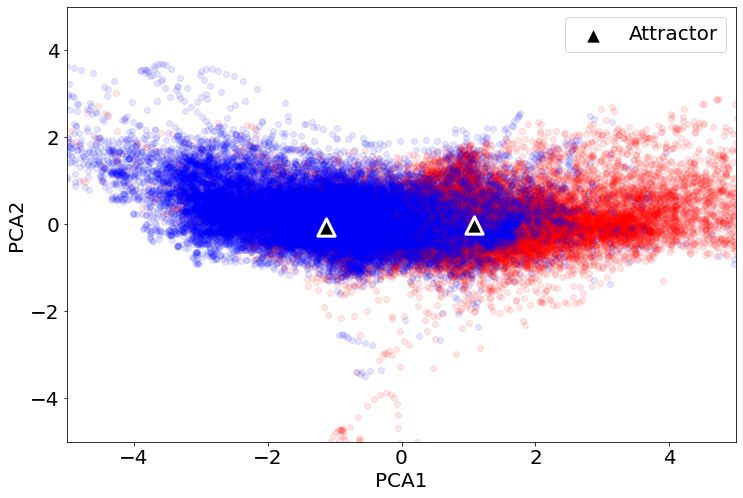

In [ ]:
save_path = None # os.path.join(save_dir, "embedding-2d.png")
plot_latent_2d(latent_projected, attractor_projected, mask * threshold_weight, lims=(-5, 5), show_legend=True, save_path=save_path)

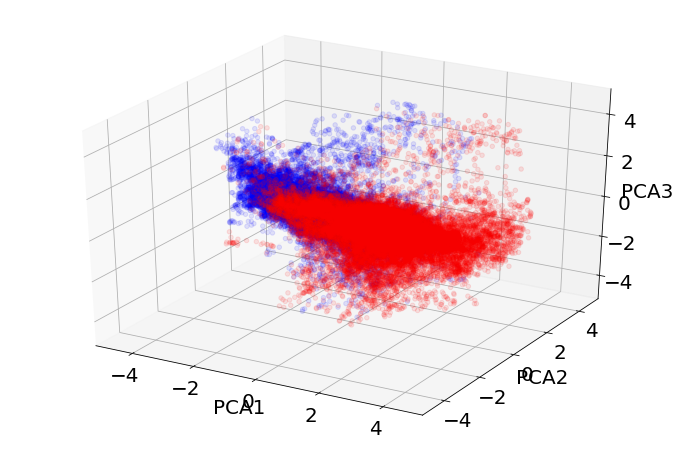

In [ ]:
save_path = None # os.path.join(save_dir, "embedding-3d.png")
plot_latent_3d(latent_projected, attractor_projected, mask * threshold_weight, lims=(-5, 5), show_legend=False, save_path=save_path)

## Extract All Training Attractor

In [ ]:
attractors = []

for idx, (waveform_mix, waveform_src) in enumerate(train_dataset):
    # May takes over 5.5 hours if you use all data
    """
    if idx >= 10000:
        break
    """
    spectrogram_src = torch.stft(waveform_src, n_fft=n_fft, hop_length=hop_length, window=window, onesided=True, return_complex=True)
    spectrogram_mix = torch.stft(waveform_mix, n_fft=n_fft, hop_length=hop_length, window=window, onesided=True, return_complex=True)
    mask = compute_ideal_binary_mask(spectrogram_src, source_dim=0)

    _, _, attractor, _ = estimate(model, spectrogram_mix, assignment=mask, threshold=threshold)

    attractors.append(attractor)

attractors = torch.cat(attractors, dim=0) # (len(train_dataset) * n_sources, embed_dim)

In [ ]:
# Compute centroids of attractors
kmeans = KMeans(K=n_sources)
cluster_ids, centroids = kmeans(attractors.unsqueeze(dim=0))
centroids = centroids.squeeze(dim=0)

In [ ]:
# Applies PCA
pca = PCA()

pca.train()
attractors_projected = pca(attractors)

pca.eval()
centroids_projected = pca(centroids)

In [ ]:
save_dir = "./PCA/analysis"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
save_path = os.path.join(save_dir, "attractor-2d.png")
plot_attractors_2d(attractors_projected, centroids_projected, lims=(-6, 6))

In [ ]:
save_path = os.path.join(save_dir, "attractor-3d.png")
plot_attractors_3d(attractors_projected, centroids_projected, lims=(-6, 6))